In [1]:
%matplotlib inline
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltools.stats import regress
from nltools.data import Brain_Data, Design_Matrix
from nltools.stats import find_spikes 


base_dir = '/Users/lukechang/Dropbox/Dartmouth/Teaching/Psych60_HumanBrainImaging/Labs/7_GLM'
data_dir = '/Volumes/Psych60/data/brainomics_data'


## View the Data on the cubicweb interface
http://brainomics.cea.fr/localizer/dataset?rql=Any%20X%2C%20XT%2C%20XL%2C%20XI%2C%20XF%2C%20XD%20WHERE%20X%20is%20Scan%2C%20X%20type%20XT%2C%20X%20label%20XL%2C%20X%20identifier%20XI%2C%20X%20format%20XF%2C%20X%20description%20XD

# Single Subject First Level Models
The first step in fMRI data analysis is to build a model for each subject to predict the activation in a single voxel over the entire scanning session. To do this, we need to build a design matrix for our general linear model. We expect distinct brain regions to be involved in processing specific aspects of our task. This means that we will construct separate regressors that model different brain processes. Here we will load a pre-made design matrix with the onsets of each trial from the Pinel Localizer task. 

The Pinel Localizer task was designed to probe several different types of basic cognitive processes, such as visual perception, finger tapping, language, and math. Several of the tasks are cued by reading text on the screen (i.e., visual modality) and also by hearing auditory instructions (i.e., auditory modality). The trials are randomized across conditions and have been optimized to maximize efficiency for a rapid event related design. There are 100 trials in total over a 5-minute scanning session. Read the [paper](https://bmcneurosci.biomedcentral.com/articles/10.1186/1471-2202-8-91) for more specific details about the task.

To build the design matrix, we will be using the Design_Matrix class from the nltools toolbox.  First, we use pandas to load the text file that contains the onset and duration for each condition of the task. Rows reflect measurements in time sampled at 1/tr cycles per second. Columns reflect distinct conditions. Conditions are either on or off. We then cast this Pandas DataFrame as a Design_Matrix object. Be sure to specify the sampling frequency, which is 1/tr. 

In [2]:
tr = 2.4
df = pd.read_csv(os.path.join(data_dir, 'Design_Matrix.csv'))
dm = Design_Matrix(df, sampling_freq=1/tr)

The Design_Matrix class is built on top of Pandas DataFrames and retains most of that functionality. There are additional methods to help with building design matrices. Be sure to check out this [tutorial](https://neurolearn.readthedocs.io/en/latest/auto_examples/01_DataOperations/plot_design_matrix.html#sphx-glr-auto-examples-01-dataoperations-plot-design-matrix-py) for more information about how to use this tool. 

We can check out details about the data using the `.info()` method.

In [3]:
dm.info()

<class 'nltools.data.design_matrix.Design_Matrix'>
RangeIndex: 128 entries, 0 to 127
Data columns (total 10 columns):
horizontal_checkerboard    128 non-null float64
motor_left_auditory        128 non-null float64
motor_left_visual          128 non-null float64
motor_right_auditory       128 non-null float64
motor_right_visual         128 non-null float64
sentence_auditory          128 non-null float64
sentence_visual            128 non-null float64
subtraction_auditory       128 non-null float64
subtraction_visual         128 non-null float64
vertical_checkerboard      128 non-null float64
dtypes: float64(10)
memory usage: 10.1 KB


We can also view the raw design matrix as a dataframe just like pd.Dataframe.  We use the `.head()` method to just post the first few rows.

In [4]:
dm.head()

,horizontal_checkerboard,motor_left_auditory,motor_left_visual,motor_right_auditory,motor_right_visual,sentence_auditory,sentence_visual,subtraction_auditory,subtraction_visual,vertical_checkerboard
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We can plot a visual representation of the design matrix using the `.heatmap()` method.

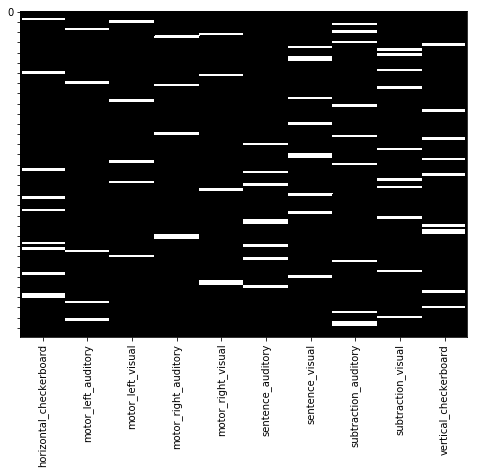

In [5]:
dm.heatmap()

## HRF Convolution
Recall what we learned about convolution in our signal processing tutorial. We can now convolve all of the onset regressors with an HRF function using the `.convolve()` method. By default it will convolve all regressors with the standard double gamma HRF function, though you can specify custom ones and also specific regressors to convolve. Check out the docstrings for more information.

/Users/lukechang/anaconda3/lib/python3.7/site-packages/nltools-0.3.11-py3.7.egg/nltools/external/hrf.py:65: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  time_stamps = np.linspace(0, time_length, float(time_length) / dt)


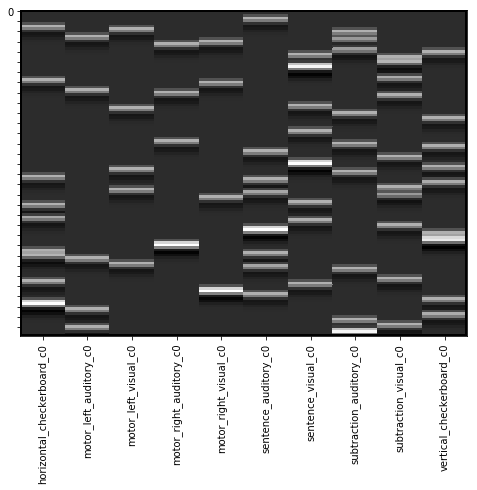

In [6]:
dm_conv = dm.convolve()
dm_conv.heatmap()

You can see that each of the regressors is now  bit blurrier and now has the shape of an HRF function. We can plot a single regoressor to see this more clearly using the `.plot()` method.

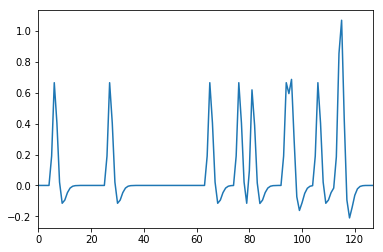

In [7]:
dm_conv['horizontal_checkerboard_c0'].plot()

Maybe we want to plot both of the checkerboard regressors.

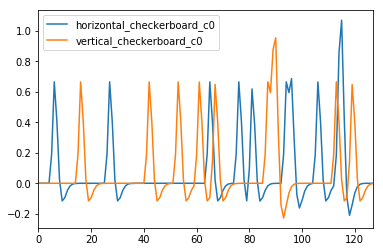

In [8]:
dm_conv[['horizontal_checkerboard_c0','vertical_checkerboard_c0']].plot()

### What about other shapes?

## Collinearity

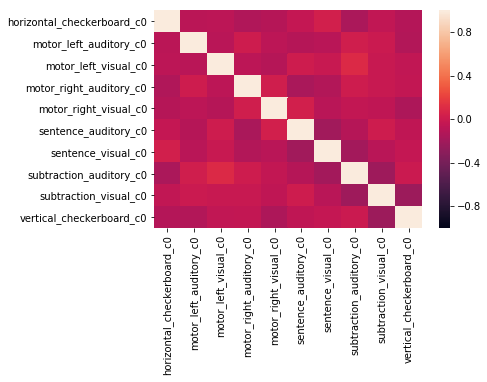

In [9]:
sns.heatmap(dm_conv.corr(), vmin=-1, vmax=1)

### Variance Inflation Factor

Text(0, 0.5, 'Variance Inflation Factor')

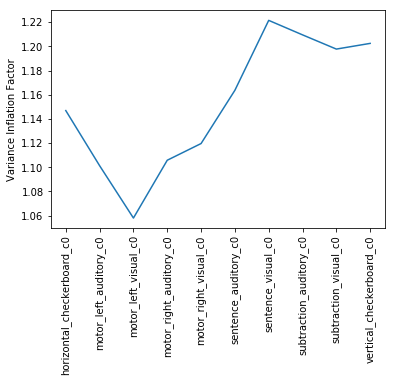

In [10]:
plt.plot(dm_conv.columns, dm_conv.vif())
plt.xticks(rotation=90)
plt.ylabel('Variance Inflation Factor')


### Orthogonalization
In general, we do not recommend using orthogonalization in most use cases.

## Filtering

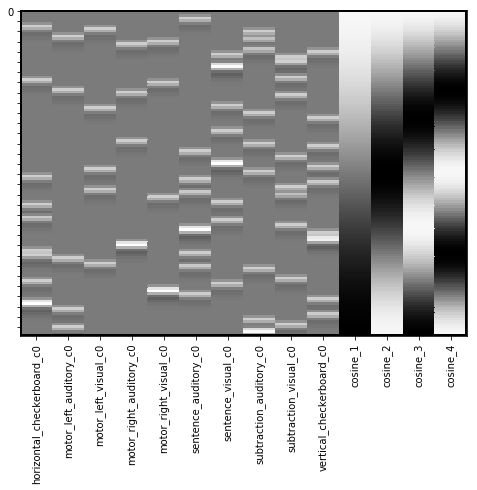

In [11]:
dm_conv_filt = dm_conv.add_dct_basis(duration=128)
dm_conv_filt.heatmap()

## Intercepts
We almost always want to include an intercept in our model. This will usually reflect the baseline, or the average voxel response during the times that are not being modeled as a regressor. It is important to note that you must have some sparsity to your model, meaning that you can't model every point in time, as this will make your model rank deficient and unestimable.

If you are concatenating runs and modeling them all together, it is recommended to include a separate intercept for each run, but not for the entire model. This means that the average response within a voxel might differ across runs. You can add an intercept by simply creating a new column of ones (e.g., `dm['Intercept] = 1`). Here we provide an example using the `.add_poly()` method, which adds an intercept by default.

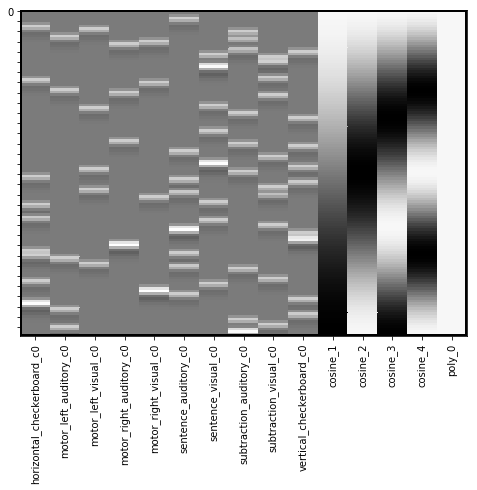

In [12]:
dm_conv_filt_poly = dm_conv_filt.add_poly()
dm_conv_filt_poly.heatmap()

## Linear Trends
We also often want to remove any slow drifts in our data.  This might include a linear trend and a quadratic trend. We can also do this with the `.add_poly()` method and adding all trends up to an order of 2 (e.g., quadratic).

Notice that these do not appear to be very different from the high pass filter basis set. It's actually okay if there is collinearity in our covariate regressors. Collinearity is only a problem when it correlates with the task regressors as it means that we will not be able to uniquely model the variance.

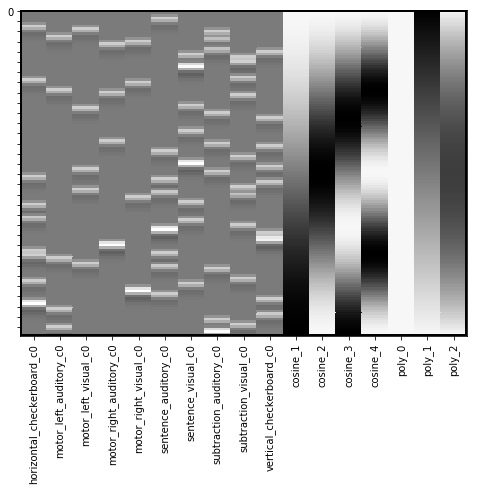

In [13]:
dm_conv_filt_poly = dm_conv_filt.add_poly(order=2, include_lower=True)
dm_conv_filt_poly.heatmap()

## Noise Covariates
Another important thing to consider is removing variance associated with head motion. Remember the preprocessed data has already realigned each TR in space, but head motion itself can nonlinearly distort the magnetic field. There are several common strategies for trying to remove artifacts associated with head motion. One is using a data driven denoising algorithm like ICA and combining it with a classifer such as FSL's [FIX](https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/FIX) module. Another approach is to include the amount of correction that needed to be applied to align each TR. For example, if someone moved a lot in a single TR, there will be a strong change in their realignment parameters. It is common to include the 6 parameters as covariates in your regression model. However, as we already noted, often motion can have a nonlinear relationship with signal intensity, so it is often good to include other transformations of these signals to capture nonlinear signal changes resulting from head motion. We typically center the six realigment parameters (or zscore) and then additionally add a quadratic version, a derivative, and the square of the derivatives, which becomes 24 additional regressors. 

In addition, it is common to model out big changes using a regressor with a single value indicating the timepoint of the movement. This will be zeros along time, with a single value of one at the time point of interest. This effectively removes any variance associated with this single time point. It is important to model each "spike" as a separate regressor as there might be distinct spatial patterns associated with different types of head motions. We strongly recommond against using a single continuous frame displacement metric as is often recommended by the fMRIprep team. This assumes (1) that there is a *linear* relationship between displacement and voxel activity, and (2) that there is a *single* spatial generator or pattern associated with frame displacement. As we saw in the ICA noise lab, there might be many different types of head motion artifacts. This procedure of including spikes as nuisance regressors is mathematically equivalent to censoring your data and removing the bad TRs. We think it is important to do this in the context of the GLM as it will also reduce the impact if it happens to covary with your task.

First, let's load preprocessed data from one participant.

In [14]:
sub = 'S01'
file_name = os.path.join(data_dir, sub ,'preprocessed_fMRI_bold.nii.gz')
data = Brain_Data(file_name)

/Users/lukechang/anaconda3/lib/python3.7/site-packages/nilearn-0.5.0-py3.7.egg/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


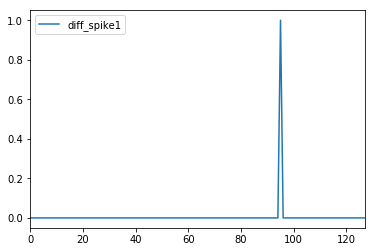

In [15]:
spikes = data.find_spikes()
spikes.iloc[:,1:].plot()

For this subject, our procedure to identify spikes only found a single spike. Let's add it to our design matrix.

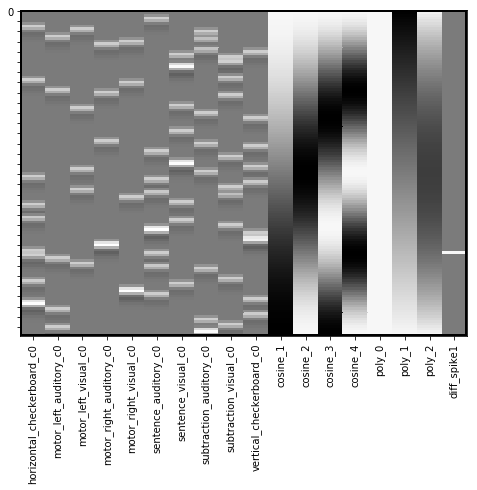

In [16]:
dm_conv_filt_poly_cov = pd.concat([dm_conv_filt_poly, spikes.iloc[:,1:]], axis=1)
dm_conv_filt_poly_cov.heatmap()

## Estimate model for all voxels

In [145]:
data.X = dm_conv_filt_poly_cov
stats = data.regress()

/Users/lukechang/anaconda3/lib/python3.7/site-packages/nltools-0.3.11-py3.7.egg/nltools/stats.py:963: RuntimeWarning: divide by zero encountered in true_divide
  t = b / stderr
/Users/lukechang/anaconda3/lib/python3.7/site-packages/nltools-0.3.11-py3.7.egg/nltools/stats.py:963: RuntimeWarning: invalid value encountered in true_divide
  t = b / stderr
/Users/lukechang/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/lukechang/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/lukechang/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1748: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0


TypeError: cannot serialize 'IndexedGzipFile' object

# Contrasts

In [3]:
sub = 'S01'
file_name = os.path.join(data_dir, sub ,'denoised_preprocessed_fMRI_bold.nii.gz')
data = Brain_Data(file_name)
data.mean()

TypeError: cannot serialize 'IndexedGzipFile' object

In [2]:
from nltools.simulator import Simulator

def sim_brain_data():
    # MNI_Template["resolution"] = request.params
    sim = Simulator()
    r = 10
    sigma = 1
    y = [0, 1]
    n_reps = 3
    dat = sim.create_data(y, sigma, reps=n_reps)
    dat.X = pd.DataFrame({'Intercept': np.ones(len(dat.Y)),
                          'X1': np.array(dat.Y).flatten()}, index=None)
    return dat

def test_sum(sim_brain_data):
    s = sim_brain_data.sum()
    assert s.shape() == sim_brain_data[1].shape()


def test_add(sim_brain_data):
    new = sim_brain_data + sim_brain_data
    assert new.shape() == shape_2d


def test_subtract(sim_brain_data):
    new = sim_brain_data - sim_brain_data
    assert new.shape() == shape_2d


def test_multiply(sim_brain_data):
    new = sim_brain_data * sim_brain_data
    assert new.shape() == shape_2d
    
d1 = sim_brain_data()

In [3]:
d1.mean()

TypeError: cannot serialize 'IndexedGzipFile' object

threshold is ignored for simple axial plots


TypeError: cannot serialize 'IndexedGzipFile' object

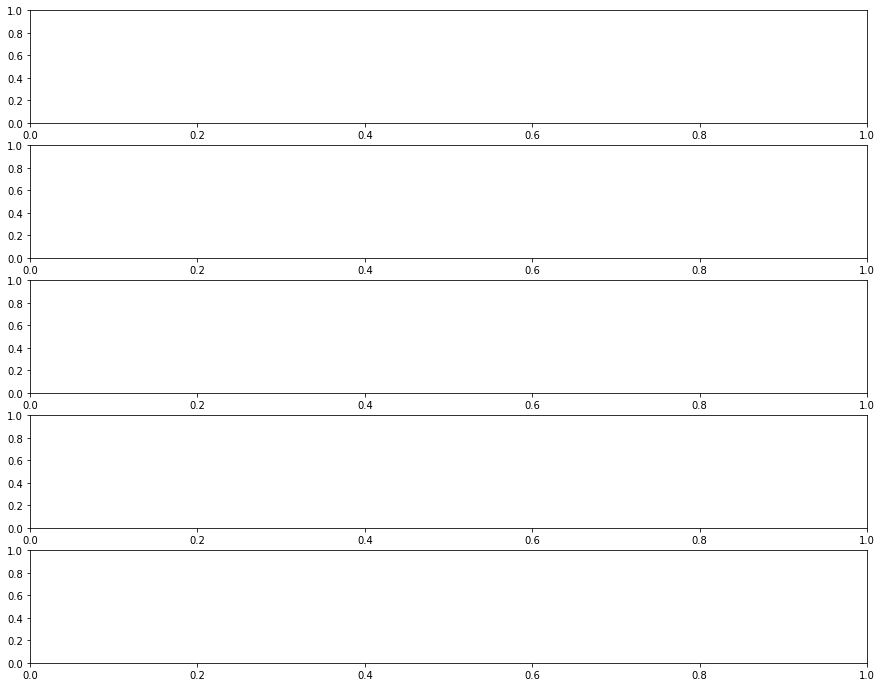

In [7]:
d1.plot()